In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Utilities as U
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
omp = 1
mpi_run = 'mpirun -np 8'

# Analysis of the band structure with QuantumESPRESSO

In [4]:
run_dir = 'Pw_bands'

We compute the band structure of Silicon and Gallium arsenide using the tools for QuantumESPRESSO

## Band structure of GaAs

The first step consists in a scf computation 

In [5]:
scf_prefix = 'gaas_scf'
bands_prefix = 'gaas_bands'

In [6]:
inp = I.PwInput(file='IO_files/gaas_scf.in')
inp.set_prefix(scf_prefix)
inp.set_energy_cutoff(60)
inp.set_kpoints(points=[6,6,6])
#inp

In [7]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True)

Initialize a parallel QuantumESPRESSO calculator with scheduler direct


In [8]:
code.run(inputs=[inp],run_dir=run_dir,names=[scf_prefix])

Skip the computation for input gaas_scf
Job completed


{'output': ['Pw_bands/gaas_scf.save/data-file-schema.xml']}

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [9]:
G = [0.,0.,0.]
X = [0.,0.,1.]
L = [0.5,0.5,0.5]
W = [1.0,0.5,0.]
K = [0.,1.,1.]

# useful to label the high-sym point on the path
high_sym = {'X':X,'L':L,'G':G,'K':K,'W':W} 

In [10]:
klist = U.build_kpath(L,G,X,K,G,numstep=30)
klist

[[0.5, 0.5, 0.5, 30],
 [0.0, 0.0, 0.0, 30],
 [0.0, 0.0, 1.0, 30],
 [0.0, 1.0, 1.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [11]:
inp.set_bands(8)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',path=klist)
#inp

In [12]:
results_gaas = code.run(inputs=[inp],run_dir=run_dir,names=[bands_prefix],source_dir=os.path.join(run_dir,scf_prefix)+'.save')
results_gaas

The folder Pw_bands/gaas_bands.save already exsists. Source folder Pw_bands/gaas_scf.save not copied
Skip the computation for input gaas_bands
Job completed


{'output': ['Pw_bands/gaas_bands.save/data-file-schema.xml']}

Once that the computation is over we can create an instance of BandStructure. The gap can be set when we init the class

In [13]:
bands_gaas = U.BandStructure.from_Pw(results_gaas['output'][0],high_sym,set_gap=1.42)

Apply a scissor of 1.1945698886779335 eV


The class contains some methods that return the bands, the kpath or the position of the high symmetry points on the path

It contains also a plot method that show the band structure

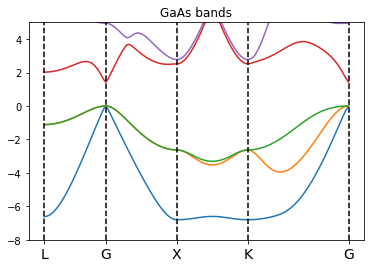

In [14]:
%matplotlib inline
plt.title('GaAs bands')
plt.ylim(-8,5)
bands_gaas.plot(plt,selection=[1,2,3,4,5])

## Band structure of GaAs with spin-orbit coupling

We repeat the computation of the band structure of GaAs including the spin-orbit. To do so we use a full relativistic pseudopotential
that is able to include the spin-orbit. 

The first step consists in a scf computation 

In [15]:
scf_prefix = 'gaas_scf_so'
nscf_prefix = 'gaas_nscf_so'
bands_prefix = 'gaas_bands_so'

In [16]:
inp = I.PwInput('IO_files/gaas_scf.in')
inp.set_prefix(scf_prefix)
inp.set_energy_cutoff(80)
inp.set_spinorbit()
inp.set_kpoints(points = [6.,6.,6.])
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp

{'control': {'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'calculation': "'scf'",
  'prefix': "'gaas_scf_so'"},
 'system': {'occupations': "'fixed'",
  'ibrav': '2',
  'celldm(1)': '10.677',
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 80,
  'lspinorb': '.true.',
  'noncolin': '.true.'},
 'electrons': {'conv_thr': '1e-08'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_rel.pz-rrkj3.UPF'],
  'As': ['1.0', 'As_rel.pz-rrkj3.UPF']},
 'atomic_positions': {'type': 'crystal',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'automatic',
  'values': ([6.0, 6.0, 6.0], [0.0, 0.0, 0.0])},
 'cell_parameters': {},
 'file': 'IO_files/gaas_scf.in'}

In [17]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True)

Initialize a parallel QuantumESPRESSO calculator with scheduler direct


In [18]:
code.run(inputs=[inp],run_dir=run_dir,names=[scf_prefix])

Skip the computation for input gaas_scf_so
Job completed


{'output': ['Pw_bands/gaas_scf_so.save/data-file-schema.xml']}

Before performing the bands computation we make an nscf computation on a regular kpath, this will be useful for the bands analysis 
using the ypp tools. 

We compute 12 bands since in this case the spin degeneracy is equal to 1 and there 8 occupied bands

In [19]:
inp.set_nscf(12,force_symmorphic=True) #use force_symmorphic = True since this computation is used as input of a Yambo computation later
inp.set_prefix(nscf_prefix)
#inp

In [20]:
code.run(inputs=[inp],run_dir=run_dir,names=[nscf_prefix],source_dir=os.path.join(run_dir,scf_prefix)+'.save',skip=False)

delete log file: Pw_bands/gaas_nscf_so.log
delete xml file: Pw_bands/gaas_nscf_so.xml
delete folder: Pw_bands/gaas_nscf_so.save
Copy source_dir Pw_bands/gaas_scf_so.save in the Pw_bands/gaas_nscf_so.save
Executing command: cd Pw_bands; mpirun -np 8 pw.x -inp gaas_nscf_so.in > gaas_nscf_so.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed


{'output': ['Pw_bands/gaas_nscf_so.save/data-file-schema.xml']}

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [21]:
G = [0.,0.,0.]
X = [0.,0.,1.]
L = [0.5,0.5,0.5]
W = [1.0,0.5,0.]
K = [0.,1.,1.]

# useful to label the high-sym point on the path
high_sym = {'X':X,'L':L,'G':G,'K':K,'W':W} 

In [22]:
klist = U.build_kpath(L,G,X,K,G,numstep=30)
klist

[[0.5, 0.5, 0.5, 30],
 [0.0, 0.0, 0.0, 30],
 [0.0, 0.0, 1.0, 30],
 [0.0, 1.0, 1.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [23]:
inp.set_bands(12)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',path=klist)
#inp

In [24]:
results_gaas_so = code.run(inputs=[inp],run_dir=run_dir,names=[bands_prefix],source_dir=os.path.join(run_dir,scf_prefix)+'.save')

The folder Pw_bands/gaas_bands_so.save already exsists. Source folder Pw_bands/gaas_scf_so.save not copied
Skip the computation for input gaas_bands_so
Job completed


Once that the computation is over we can create an instance of BandStructure

In [25]:
bands_gaas_so = U.BandStructure.from_Pw(results_gaas_so['output'][0],high_sym,set_gap=1.42)

Apply a scissor of 1.0019927808099969 eV


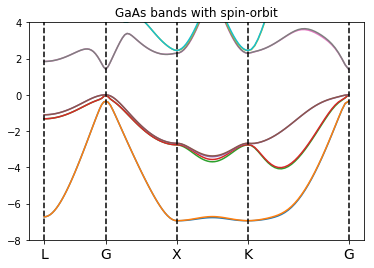

In [26]:
%matplotlib inline
plt.title('GaAs bands with spin-orbit')
plt.ylim(-8,4)
bands_gaas_so.plot(plt,selection=[2,3,4,5,6,7,8,9,10,11])

Note that in this case we need to display twice the bands respect to the previous example since each band accomodate only one electron in
a specific spin state. 

## Band structure of Silicon

The first step consists in a scf computation 

In [27]:
scf_prefix = 'si_scf'
bands_prefix = 'si_bands'

In [28]:
inp = I.PwInput(file='IO_files/si_scf.in')
inp.set_prefix(scf_prefix)
inp.set_energy_cutoff(60)
inp.set_kpoints(points=[6,6,6])
#inp

In [29]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True)

Initialize a parallel QuantumESPRESSO calculator with scheduler direct


In [30]:
code.run(inputs=[inp],run_dir=run_dir,names=[scf_prefix])

Skip the computation for input si_scf
Job completed


{'output': ['Pw_bands/si_scf.save/data-file-schema.xml']}

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [31]:
G = [0.,0.,0.]
X = [0.,0.,1.]
L = [0.5,0.5,0.5]
W = [1.0,0.5,0.]
K = [0.,1.,1.]

# useful to label the high-sym point on the path
high_sym = {'X':X,'L':L,'G':G,'K':K,'W':W} 

In [32]:
klist = U.build_kpath(L,G,X,K,G,numstep=30)
#klist

In [33]:
inp.set_bands(8)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',path=klist)
#inp

In [34]:
results_si = code.run(inputs=[inp],run_dir=run_dir,names=[bands_prefix],source_dir=os.path.join(run_dir,scf_prefix)+'.save')

The folder Pw_bands/si_bands.save already exsists. Source folder Pw_bands/si_scf.save not copied
Skip the computation for input si_bands
Job completed


Once that the computation is over we can create an instance of PwBands

In [35]:
bands_si = U.BandStructure.from_Pw(results_si['output'][0],high_sym,set_gap=1.2)

Apply a scissor of 0.6044443799174577 eV


It contains also a plot method that show the band structure

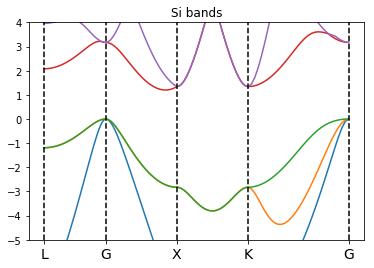

In [36]:
%matplotlib inline
plt.title('Si bands')
plt.ylim(-5,4)
bands_si.plot(plt,selection=[1,2,3,4,5])

## Band structure of Graphene

In [37]:
scf_prefix = 'graphene_scf'
nscf_prefix = 'graphene_nscf'
bands_prefix = 'graphene_bands'

The lattice is oriented with the zig-zag along the y axis. The basis vector are chosen as:

$$
a_1 = \frac{a}{2}(3,\sqrt{3},0) \, ,\quad a_2 = \frac{a}{2}(3,-\sqrt{3},0) \, ,\quad
a_3 = (0,0,\delta_z)
$$

Here $a$ represents the CC nn distance. The position of the atoms in the lattice is given by:

$$
A = (0,0,0) \, \qquad B = \frac{a}{2}(1,\sqrt{3},0)
$$
The lattice constant is given by $a_{lat} = \sqrt{3}a$.

The position of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) are given by:

$$
M = (\frac{1}{\sqrt{3}},0) \, \quad
K = (\frac{1}{\sqrt{3}},\frac{1}{3}) 
$$

In [38]:
pseudo_pbe = 'C_pbe-20082014.UPF' #pbe
delta = 15 # Angstrom
a0 = 1.42495 # PBE cc equilibrium distance among nearest C atoms
engCutoff = 60 # Ry
numKpoints = 12

import numpy as np
a1 = [a0/2.*3.,a0/2.*np.sqrt(3.),0.]
a2 = [a0/2.*3.,-a0/2.*np.sqrt(3.),0.]
a3 = [0.,0.,delta]
A = [0.,0.,0.]
B = [a0/2.,a0/2.*np.sqrt(3.),0.]

In [39]:
inp = I.PwInput()
inp.set_scf()
inp.set_prefix(scf_prefix)
inp.set_pseudo_dir()
inp.add_atom(atom='C',pseudo_name=pseudo_pbe,mass=12.011)
inp.set_atoms_number(2)
inp.set_energy_cutoff(engCutoff)
inp.set_atomic_positions([['C',A],['C',B]],type='angstrom')
inp.set_lattice(ibrav=0,cell_vectors=[a1,a2,a3],cell_units='angstrom')
inp.set_occupations(occupations='smearing',degauss=50.)
inp.set_kpoints(points = [numKpoints,numKpoints,1])
#inp

In [40]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True)

Initialize a parallel QuantumESPRESSO calculator with scheduler direct


In [41]:
code.run(inputs=[inp],run_dir=run_dir,names=[scf_prefix])

Skip the computation for input graphene_scf
Job completed


{'output': ['Pw_bands/graphene_scf.save/data-file-schema.xml']}

We perfrom also a nscf computation on a regular grid of kpoint. Results of this computation are used by the
other tutorials of the package

In [42]:
inp.set_nscf(8)
inp.set_prefix(nscf_prefix)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'graphene_nscf'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.false.',
  'ntyp': '1',
  'nat': '2',
  'ecutwfc': 60,
  'ibrav': 0,
  'occupations': "'smearing'",
  'smearing': "'fermi-dirac'",
  'degauss': 0.00367493225078649,
  'nbnd': 8},
 'electrons': {'conv_thr': 1e-08, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'C': [12.011, 'C_pbe-20082014.UPF']},
 'atomic_positions': {'type': 'angstrom',
  'values': [['C', [0.0, 0.0, 0.0]],
   ['C', [0.712475, 1.2340428991226358, 0.0]]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {'type': 'angstrom',
  'values': [[2.137425, 1.2340428991226358, 0.0],
   [2.137425, -1.2340428991226358, 0.0],
   [0.0, 0.0, 15]]}}

In [43]:
code.run(inputs=[inp],run_dir=run_dir,names=[nscf_prefix],source_dir=os.path.join(run_dir,scf_prefix)+'.save')

The folder Pw_bands/graphene_nscf.save already exsists. Source folder Pw_bands/graphene_scf.save not copied
Skip the computation for input graphene_nscf
Job completed


{'output': ['Pw_bands/graphene_nscf.save/data-file-schema.xml']}

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [44]:
G = [0.,0.,0.]
M = [1./np.sqrt(3.),0.,0.]
K = [1./np.sqrt(3.),1./3.,0.]

# useful to label the high-sym point on the path
high_sym = {'G':G,'K':K,'M':M}

In [45]:
klist = U.build_kpath(G,M,K,G,numstep=30)
#klist

In [46]:
inp.set_bands(8)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',path=klist)
#inp

In [47]:
results_gra = code.run(inputs=[inp],run_dir=run_dir,names=[bands_prefix],source_dir=os.path.join(run_dir,scf_prefix)+'.save')

The folder Pw_bands/graphene_bands.save already exsists. Source folder Pw_bands/graphene_scf.save not copied
Skip the computation for input graphene_bands
Job completed


Once that the computation is over we can create an instance of PwBands

In [48]:
bands_gra = U.BandStructure.from_Pw(results_gra['output'][0],high_sym)

It contains also a plot method that show the band structure

In [49]:
bands_gra.get_high_sym_positions()

(['G', 'G', 'K', 'M'],
 [0.0, 1.5773502657018026, 0.9106835999999987, 0.57735027])

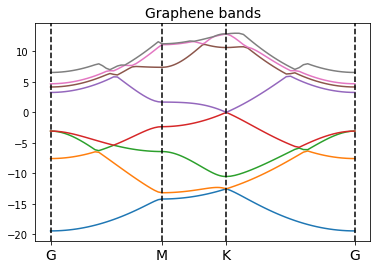

In [50]:
%matplotlib inline
plt.title('Graphene bands',size=14)
#plt.ylim(-6,8)
bands_gra.plot(plt) #,selection=[0,1,2,3,4,5,6,7]

# Analysis of the band structure with ypp

In [51]:
run_dir = 'Ypp_bands'

Now we analyze the band structure using the post processing tools of ypp. 

## Band structure of GaAs with spin-orbit coupling

As an example we consider the GaAs band structure with spin-orbit coupling. 

We perform a yy -s b computation starting from the .save of an nscf pw computation on a regular grid

In [52]:
U.build_SAVE('Pw_bands/gaas_nscf_so.save',run_dir)

Executing command: cd Pw_bands/gaas_nscf_so.save; p2y -a 2
Executing command: ln -s /home/marco/Applications/MPPI/sphinx_source/tutorials/Pw_bands/gaas_nscf_so.save/SAVE /home/marco/Applications/MPPI/sphinx_source/tutorials/Ypp_bands
Executing command: cd Ypp_bands;OMP_NUM_THREADS=1 yambo


In [53]:
inp = I.YamboInput(args='ypp -s b',folder=run_dir,filename='ypp.in') 
inp['variables']['OutputAlat'] = [10.677,'']
#inp

In [54]:
code = C.YamboCalculator(mpi_run='mpirun -np 1',executable='ypp',skip=False)

Initialize a parallel Yambo calculator with scheduler direct


Set the input parameter to perform the band computation along a path

In [55]:
# set the coordinate of the high-sym points 
G = [0.,0.,0.]
X = [0.,0.,1.]
L = [0.5,0.5,0.5]
W = [1.0,0.5,0.]
K = [0.,1.,1.]

# useful to label the high-sym point on the path
high_sym = {'X':X,'L':L,'G':G,'K':K,'W':W} 

# set the path (use the same path of the pw computation)
path = [L,G,X,K,G]
# set the number of intermediate points between two high-sym ones
bands_step = 30

In [56]:
# scissor
# inp['variables']['GfnQP_E'] = [1.0,1.0,1.0]

# band structure
inp['variables']['BANDS_steps'] = [bands_step,'']
inp['variables']['BANDS_kpts'] = [path,'']
inp['variables']['cooIn'] = 'alat'
inp['variables']['cooOut'] = 'alat'
inp

{'args': 'ypp -s b',
 'folder': 'Ypp_bands',
 'filename': 'ypp.in',
 'arguments': [],
 'variables': {'OutputAlat': [10.677, ''],
  'INTERP_Shell_Fac': [20.0, ''],
  'BANDS_steps': [30, ''],
  'INTERP_mode': 'NN',
  'cooIn': 'alat',
  'cooOut': 'alat',
  'CIRCUIT_E_DB_path': 'none',
  'BANDS_bands': [[1, 12], ''],
  'INTERP_Grid': [['-1', '-1', '-1'], ''],
  'BANDS_kpts': [[[0.5, 0.5, 0.5],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 1.0, 1.0],
    [0.0, 0.0, 0.0]],
   '']}}

In [57]:
results_ypp = code.run(run_dir=run_dir,inputs=[inp],names=['gaas_bands_so'])
results_ypp

delete folder: Ypp_bands/gaas_bands_so
Executing command: cd Ypp_bands; mpirun -np 1 ypp -F gaas_bands_so.in -J gaas_bands_so -C gaas_bands_so
run0_is_running:True  
Job completed


{'output': [['Ypp_bands/gaas_bands_so/o-gaas_bands_so.magnetization_y',
   'Ypp_bands/gaas_bands_so/o-gaas_bands_so.magnetization_x',
   'Ypp_bands/gaas_bands_so/o-gaas_bands_so.bands_interpolated',
   'Ypp_bands/gaas_bands_so/o-gaas_bands_so.magnetization_z',
   'Ypp_bands/gaas_bands_so/o-gaas_bands_so.spin_factors_DN',
   'Ypp_bands/gaas_bands_so/o-gaas_bands_so.spin_factors_UP']],
 'dbs': ['Ypp_bands/gaas_bands_so']}

Once that the computation is over we can create an instance of PwBands

In [58]:
U.BandStructure.from_Ypp?

Signature: U.BandStructure.from_Ypp(results, high_sym_points, suffix='bands_interpolated')
Docstring:
Initialize the BandStructure class from the result of a Ypp postprocessing.
The class make usage of the YamboParser of this package.

Args:
    results (:py:class:`list`) : list that contiains the o- file provided as the output of a
        Ypp computation. results is the key ['output'][irun] of the run method of YamboCalculator
    high_sym_points(:py:class:`dict`) : dictionary with name and coordinates of the
                    high_sym_points of the path
    suffix (string) : specifies the suffix of the o- file use to build the bands
File:      ~/Applications/MPPI/mppi/Utilities/BandStructure.py
Type:      method


In [59]:
bands_ypp = U.BandStructure.from_Ypp(results_ypp['output'][0],high_sym)

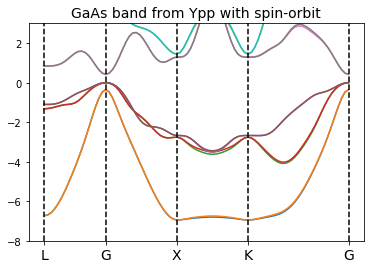

In [60]:
%matplotlib inline
plt.title('GaAs band from Ypp with spin-orbit',size=14)
plt.ylim(-8,3)
bands_ypp.plot(plt,selection=[2,3,4,5,6,7,8,9,10,11])

The desing of the plot method of the class allows us to plot bands coming from different calculations in the same plot.

For instance, we can show the effect of the spin-orbit on the valence band of GaAs

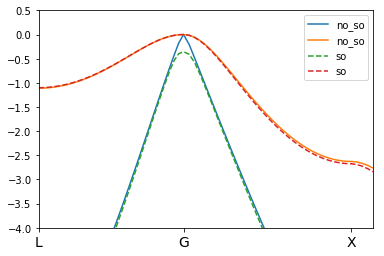

In [61]:
bands_gaas.plot(plt,selection= [1,3],label='no_so',show_vertical_lines=False)
bands_gaas_so.plot(plt,selection = [2,6],ls='--',label='so',show_vertical_lines=False)
plt.ylim(-4,0.5)
plt.xlim(0,2)
plt.legend()

The shift of the split-off band is visible.